# Import Librarys and Files

## Imports

### Add top level to the import path

In [1]:
import sys
import os

# Add the project root to sys.path
project_root = os.path.abspath("../..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

### Import some classes/modules we'll be using

In [2]:
import ROOT as r
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from importlib import reload
from tqdm.notebook import tqdm 
from datetime import datetime


import deprecated.utils.utils as utils
import deprecated.utils.plotting_utils as plotting_utils
from deprecated.models.event_patterns import EventPatterns
from models.pattern import Pattern
from models.vertex import Vertex
from models.tracklet import Tracklet
from models.hit import Hit

## Load Shared libraries to access methods of ROOT objects in python

In [3]:
PI_ROOT_DICT_PATH = "/home/jack/large_projects/simulation/install/lib/libPiRootDict.so" #Change to match system path
r.gSystem.Load(PI_ROOT_DICT_PATH)

0

## Load Pattern finding truth data
This also contains what we need to reconstruct patterns. So it gives validation (true patterns) and a method to create our own pattern

In [4]:
data_dir = "/home/jack/large_projects/simulation/workspace/playground/reco_algorithm_tests/data/" #CHANGE THIS
file_truth_pattern_finding = "all_rec_pimunu_tracklets_truth.root" #CHANGE THIS

# Combine directory and file name
file_truth_pattern_finding_path = os.path.join(data_dir, file_truth_pattern_finding)

# Print creation time for the full file path
utils.print_file_creation_time(file_truth_pattern_finding_path)

# Open the file
file_truth_pf = r.TFile(file_truth_pattern_finding_path, "READ")


The file '/home/jack/large_projects/simulation/workspace/playground/reco_algorithm_tests/data/all_rec_pimunu_tracklets_truth.root' was created on: 2025-04-23 14:53:39


## Get ROOT objects from our file
Making these more than once can cause memory leaks

In [5]:
tree = file_truth_pf.Get("rec")
geoHelper = file_truth_pf.Get("GeoHeader")

# Reconstruct Multiple Events

## Make cuts on the data set

In [6]:
# Number of events to process (set to None or a large number to process all events)
MAX_EVENTS = None
N_EVENTS = tree.GetEntries() if MAX_EVENTS is None else min(MAX_EVENTS, tree_pf.GetEntries())

use_pitar = True
use_in_fid_vol = True

nentries = tree.GetEntries()
all_events = []  # Store event IDs of all events that pass the initial cuts

for iEntry in tqdm(range(min(nentries, N_EVENTS)), desc="Processing Events"):

    patternFailed = False
    tree.GetEntry(iEntry)

    # SELECTIONS
    pitar = any(info.Has(r.kPitar) for info in tree.infoVec)

    if (not pitar) and use_pitar:
        continue

    in_fid_vol = True
    for tracklet in tree.trackletVec:
        for hit in tracklet.GetAllHits():
            vname = geoHelper.GetVolumeName(hit.GetVID()).Data()
            if 'atar' in vname:
                side = vname[11]
                if (side == "f" and abs(geoHelper.GetX(hit.GetVID())) > 8) or \
                   (side == "b" and abs(geoHelper.GetY(hit.GetVID())) > 8):
                    in_fid_vol = False

    if (not in_fid_vol) and use_in_fid_vol:
        continue

    all_events.append(iEntry)

Processing Events:   0%|          | 0/58659 [00:00<?, ?it/s]

## Run Reconstruction on Events

In [7]:
from algorithms.tracklet.default_tracklet_former import DefaultTrackletFormer
from algorithms.vertex.kmeans_vertex_former import KMeansVertexFormer
from algorithms.pattern.default_pattern_former import DefaultPatternFormer
from deprecated.algorithms.validation.tracklet_grouping_validator import TrackletGroupingValidator

# Preallocate array
reconstructed_events = np.empty(len(all_events), dtype=object)

# tqdm with simple progress description
with tqdm(total=len(all_events), desc="Reconstructing events") as pbar:
    for i, event_index in enumerate(all_events):
        event_patterns = EventPatterns(event_index, DefaultTrackletFormer(), KMeansVertexFormer(), DefaultPatternFormer(), TrackletGroupingValidator())
        event_patterns.form_all(tree, geoHelper, event_index)
        reconstructed_events[i] = event_patterns
        pbar.update(1)


Reconstructing events:   0%|          | 0/44698 [00:00<?, ?it/s]

# Check/View Algorithm Performance

## Performance vs. Particle composition

### Performance categorized by reconstructed particle componsition
Sometimes tracklets exist in truth, but do not create a hit in the atar. As a result, we cannot always construct the true particle composition.

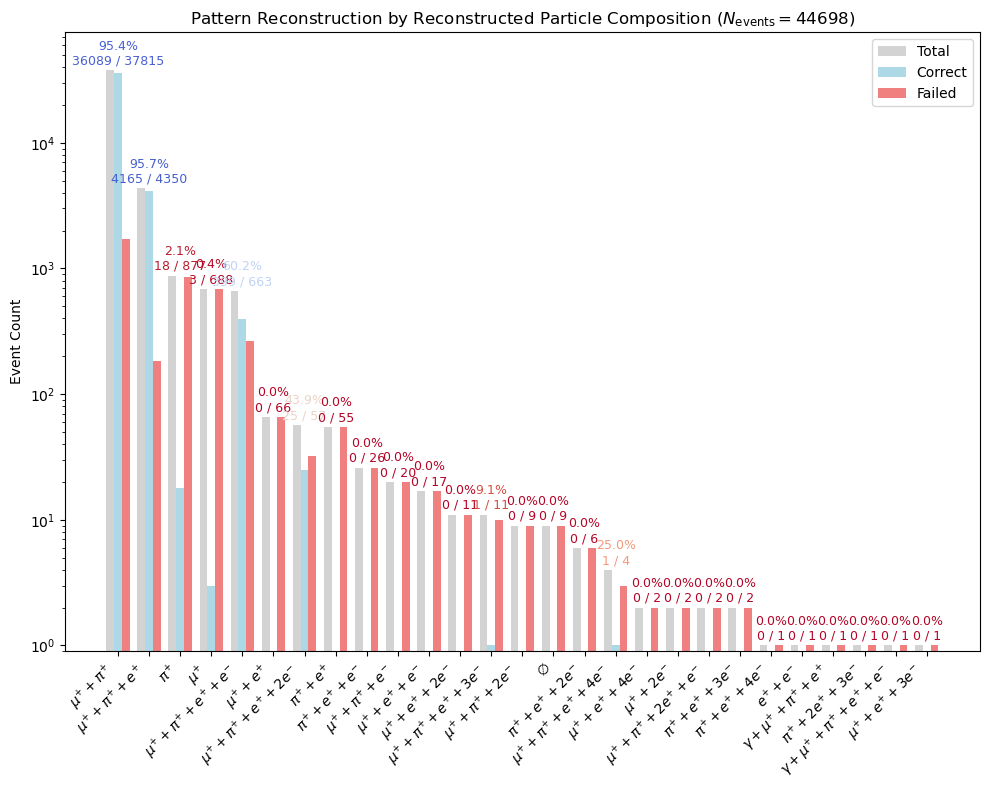

In [8]:
reload(plotting_utils)
title = f"Pattern Reconstruction by Reconstructed Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_classification_from_patterns(reconstructed_events, use_truth_particles = False, title =  title)

### Performance categorized by true particle componsition
We can tag each event with the true particle composition information and plot against that instead to also see performance based on true particle composition

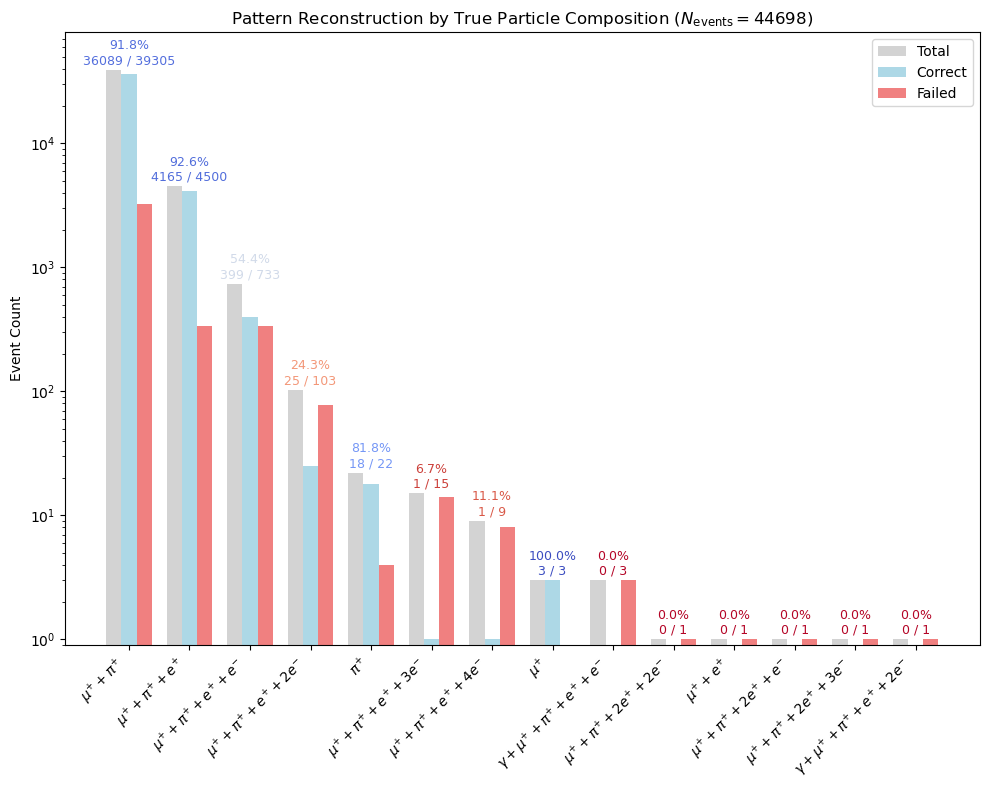

In [9]:
reload(plotting_utils)
title = f"Pattern Reconstruction by True Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_classification_from_patterns(reconstructed_events, use_truth_particles = True, title =  title)

## Performance vs. True Number of Patterns

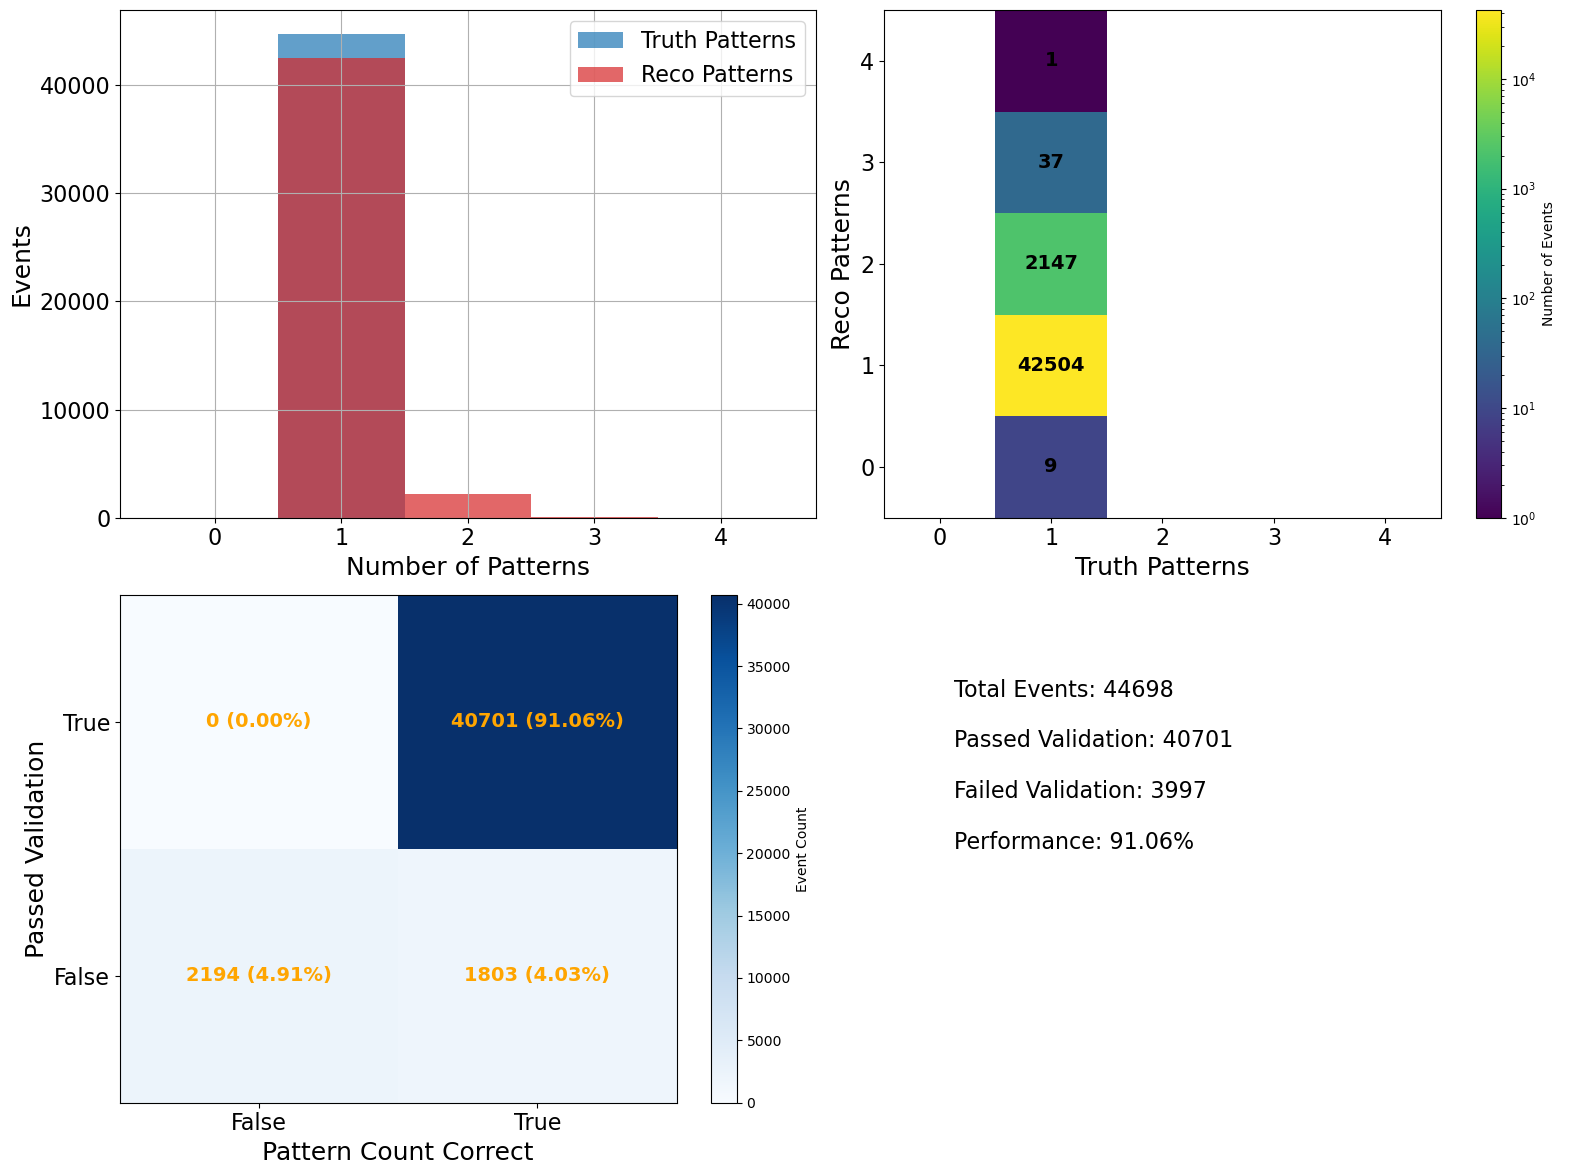

In [10]:
reload(plotting_utils)
title = f"Pattern Reconstruction by True Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_patterns_summary(reconstructed_events, title =  None)

## Performance vs. Using front/back Vertex
The kmeans algorithm is applies to the "front" planes or (x,z) coordinates and the "back" planes or (y,z) coordinates. Sometimes, they can group tracklets into vertices differently.

### Performance vs. Front/back Vertices agreement


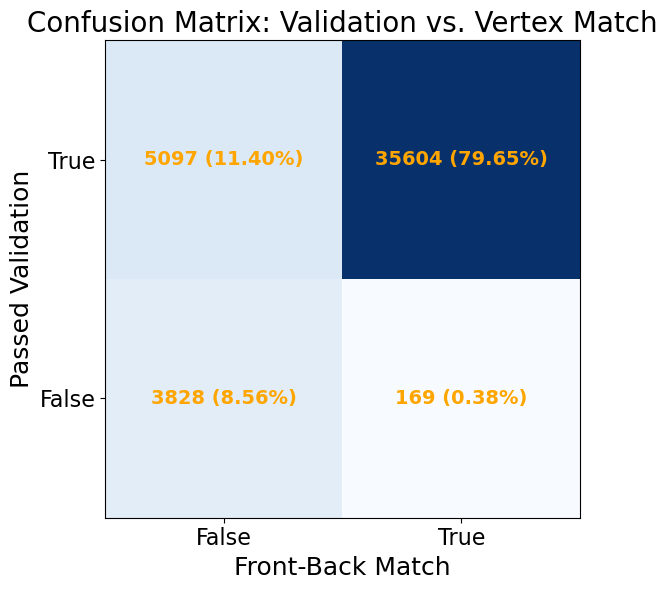

In [11]:
reload(plotting_utils)

# Extract metrics
vertex_match = []
validation_passed = []

for ep in reconstructed_events:
    vertex_info = ep.extra_info.get("vertex_algorithm_info", {})
    
    # Get the vertex comparison data
    vertex_comparison = vertex_info.get("vertex_comparison", {})
    
    # Check if the vertex sets for front, back, and both are equal
    front_vertices = vertex_comparison.get("front_vertices", set())
    back_vertices = vertex_comparison.get("back_vertices", set())

    # Compare the vertex sets (you can adjust the comparison logic if needed)
    match = (front_vertices == back_vertices)

    # Validate the event
    validated = ep.validate()

    vertex_match.append(match)
    validation_passed.append(validated)

    if validated and not match:
        patterns_truth = ep.extra_info.get("tracklet_algorithm_info", {}).get("patterns_truth", {})
        reconstructed_tracklet_ids = sorted([
            t.tracklet_id
            for pattern in ep.get_patterns()
            for t in pattern.get_unique_tracklets()
        ])

# Plot confusion matrix (swapped axes)
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix, im = plotting_utils.plot_confusion_matrix(
    ax,
    metric1=validation_passed,         # now on Y axis
    metric2=vertex_match,              # now on X axis
    total=len(reconstructed_events),
    x_axis_label="Front-Back Match",
    y_axis_label="Passed Validation"
)
plt.title("Confusion Matrix: Validation vs. Vertex Match", fontsize=20)
plt.tight_layout()
plt.show()


### Performance vs. Front/Back Vertices (validated using each)

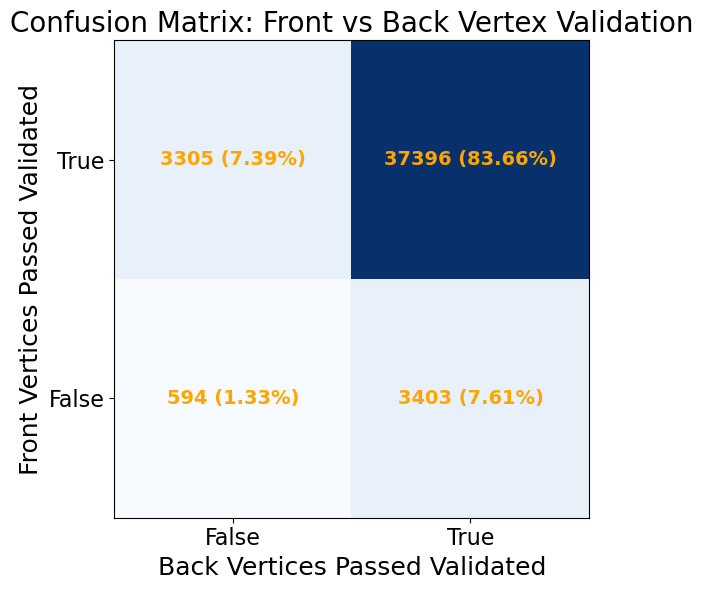

In [12]:
reload(plotting_utils)

# Collect validation results
validation_front = []
validation_back = []

for ep in reconstructed_events:
    # Step 1: Temporarily use back vertices for validation
    back_vertices = ep.extra_info.get("vertex_algorithm_info", {}).get("vertex_comparison", {}).get("back_vertices", set())
    ep.patterns = {Pattern(0, back_vertices)}
    ep.form_patterns()
    validated_back = ep.validate()
    validation_back.append(validated_back)

    # Step 2: Use front vertices for validation
    front_vertices = ep.extra_info.get("vertex_algorithm_info", {}).get("vertex_comparison", {}).get("front_vertices", set())
    ep.patterns = {Pattern(0, front_vertices)}
    ep.form_patterns()
    validated_front = ep.validate()
    validation_front.append(validated_front)

# Plot confusion matrix: front vs back validation
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix, im = plotting_utils.plot_confusion_matrix(
    ax,
    metric1=validation_front,     # Y-axis
    metric2=validation_back,      # X-axis
    total=len(reconstructed_events),
    x_axis_label="Back Vertices Passed Validated",
    y_axis_label="Front Vertices Passed Validated"
)
plt.title("Confusion Matrix: Front vs Back Vertex Validation", fontsize=20)
plt.tight_layout()
plt.show()


## Performance vs choice of sigma and n_iters parameters

### Gather data by varying parameters
This will likely take a while, depending on how big your data set and scan are

In [ ]:
# Parameters for sigma and n_iters to test
sigma_values = [0.1, 0.5, 1, 5, 10]  # Updated sigma values
n_iters_values = [1, 3, 5, 10, 25]  # Updated n_iters values

# Validation results storage (for heatmap)
validation_results = []

# Create a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define the output file name with the timestamp
output_file_name = f"validation_results_{timestamp}.csv"

# Combine the data directory with the output file name
output_file_path = os.path.join(data_dir, output_file_name)

# tqdm with simple progress description
total_events = len(all_events)
total_combinations = total_events * len(sigma_values) * len(n_iters_values)

with tqdm(total=total_combinations, desc="Reconstructing events") as pbar:
    for event_index in all_events:
        for sigma in sigma_values:
            for n_iters in n_iters_values:
                kmeans_vertex_former = KMeansVertexFormer(n_iters=n_iters, sigma=sigma, plane="front", planes_to_run={"front"})
                event_patterns = EventPatterns(
                    event_index,
                    DefaultTrackletFormer(),
                    kmeans_vertex_former,
                    DefaultPatternFormer(),
                    TrackletGroupingValidator()
                )
                event_patterns.form_all(tree, geoHelper, event_index)
                validated = event_patterns.validate()
                validation_results.append([event_index, sigma, n_iters, validated])
                pbar.set_postfix({"Event": event_index, "Validated": validated, "Sigma": sigma, "N_Iters": n_iters})
                pbar.update(1)

# Save final results
validation_df = pd.DataFrame(validation_results, columns=["Event_Index", "Sigma", "N_Iters", "Validated"])
validation_df.to_csv(output_file_path, index=False)


Reconstructing events:   0%|          | 0/1117450 [00:00<?, ?it/s]

### Average validation over events

In [ ]:
# Option: Set path to a saved validation result CSV
load_from_file = True  # Set to False to skip loading
loaded_file_path = "/home/jack/large_projects/simulation/workspace/playground/reco_algorithm_tests/data/validation_results_20250416_193108.csv"  # Or set manually to a specific file

if load_from_file and os.path.exists(loaded_file_path):
    validation_df = pd.read_csv(loaded_file_path)
    print(f"Loaded validation results from: {loaded_file_path}")
else:
    print("No file loaded; using existing validation_df in memory.")

# Compute averages
unique_combinations = validation_df[["Sigma", "N_Iters"]].drop_duplicates().values
averaged_results = []

for sigma, n_iters in unique_combinations:
    subset = validation_df[
        (validation_df["Sigma"] == sigma) & (validation_df["N_Iters"] == n_iters)
    ]
    count = len(subset)
    p = subset["Validated"].mean()
    uncertainty = (p * (1 - p))**0.5 / count**0.5 if count > 0 else 0
    averaged_results.append([sigma, n_iters, p, uncertainty])

average_df = pd.DataFrame(averaged_results, columns=["Sigma", "N_Iters", "Average_Validated", "Uncertainty"])
average_df = average_df.sort_values(by=["Sigma", "N_Iters"]).reset_index(drop=True)
average_df


### Plot results

In [ ]:
import numpy as np

def round_to_significant(x):
    """Round uncertainty up to the first significant digit and return both value and precision."""
    if x == 0:
        return 0.0, 0  # No uncertainty
    order = int(np.floor(np.log10(abs(x))))
    precision = -order
    rounded = np.ceil(x * 10**precision) / 10**precision
    return rounded, precision

# Pivot tables
value_pivot = average_df.pivot(index="Sigma", columns="N_Iters", values="Average_Validated")
uncertainty_pivot = average_df.pivot(index="Sigma", columns="N_Iters", values="Uncertainty")

heatmap_data = value_pivot.values
uncertainty_data = uncertainty_pivot.values
x_labels = value_pivot.columns.tolist()
y_labels = value_pivot.index.tolist()

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(heatmap_data, cmap="viridis", aspect="auto", origin="lower")

# Annotate with smart-rounded values
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        value = heatmap_data[i, j]
        unc_raw = uncertainty_data[i, j]
        unc_rounded, precision = round_to_significant(unc_raw)
        val_rounded = round(value, precision)
        text_color = "white" if value < 0.5 else "black"
        ax.text(j, i, f"{val_rounded:.{precision}f}\n±{unc_rounded:.{precision}f}", 
                ha="center", va="center", color=text_color, fontsize=9)

# Axis setup
ax.set_xticks(np.arange(len(x_labels)))
ax.set_yticks(np.arange(len(y_labels)))
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("N_Iters", fontsize=12)
ax.set_ylabel("Sigma", fontsize=12)
ax.set_title("Avg. Validation Score ± Uncertainty (Rounded by Significance)", fontsize=16)

fig.colorbar(cax, label="Average Validation Score")
plt.tight_layout()
plt.show()


## Performance when using both planes to make 3D endpoints

### Reconstruct events using both planes of information

In [ ]:
from algorithms.tracklet.default_tracklet_former import DefaultTrackletFormer
from algorithms.vertex.kmeans_vertex_former import KMeansVertexFormer
from algorithms.pattern.default_pattern_former import DefaultPatternFormer
from deprecated.algorithms.validation.tracklet_grouping_validator import TrackletGroupingValidator

# Preallocate array
reconstructed_events = np.empty(len(all_events), dtype=object)

# tqdm with simple progress description
with tqdm(total=len(all_events), desc="Reconstructing events") as pbar:
    for i, event_index in enumerate(all_events):
        event_patterns = EventPatterns(event_index, DefaultTrackletFormer(), KMeansVertexFormer(plane="both"), DefaultPatternFormer(), TrackletGroupingValidator())
        event_patterns.form_all(tree, geoHelper, event_index)
        reconstructed_events[i] = event_patterns
        pbar.update(1)


### Performance vs. Particle Composition

In [ ]:
reload(plotting_utils)
title = f"Pattern Reconstruction by Reconstructed Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_classification_from_patterns(reconstructed_events, use_truth_particles = False, title =  title)

In [ ]:
reload(plotting_utils)
title = f"Pattern Reconstruction by True Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_classification_from_patterns(reconstructed_events, use_truth_particles = True, title =  title)

### Performance vs. Number of patterns found

In [ ]:
reload(plotting_utils)
title = f"Pattern Reconstruction by True Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_patterns_summary(reconstructed_events, title =  None)

### Performance vs. If front and back planes reach same results

In [ ]:
reload(plotting_utils)

# Extract metrics
vertex_match = []
validation_passed = []

for ep in reconstructed_events:
    vertex_info = ep.extra_info.get("vertex_algorithm_info", {})
    
    # Get the vertex comparison data
    vertex_comparison = vertex_info.get("vertex_comparison", {})
    
    # Check if the vertex sets for front, back, and both are equal
    front_vertices = vertex_comparison.get("front_vertices", set())
    back_vertices = vertex_comparison.get("back_vertices", set())

    # Compare the vertex sets (you can adjust the comparison logic if needed)
    match = (front_vertices == back_vertices)

    # Validate the event
    validated = ep.validate()

    vertex_match.append(match)
    validation_passed.append(validated)

    if validated and not match:
        patterns_truth = ep.extra_info.get("tracklet_algorithm_info", {}).get("patterns_truth", {})
        reconstructed_tracklet_ids = sorted([
            t.tracklet_id
            for pattern in ep.get_patterns()
            for t in pattern.get_unique_tracklets()
        ])

# Plot confusion matrix (swapped axes)
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix, im = plotting_utils.plot_confusion_matrix(
    ax,
    metric1=validation_passed,         # now on Y axis
    metric2=vertex_match,              # now on X axis
    total=len(reconstructed_events),
    x_axis_label="Front-Back Match",
    y_axis_label="Passed Validation"
)
plt.title("Confusion Matrix: Validation vs. Vertex Match", fontsize=20)
plt.tight_layout()
plt.show()


## Check on k_means perfromance each iteratiom

### Reconstruct using many n_iters

In [ ]:
from algorithms.tracklet.default_tracklet_former import DefaultTrackletFormer
from algorithms.vertex.kmeans_vertex_former import KMeansVertexFormer
from algorithms.pattern.default_pattern_former import DefaultPatternFormer
from deprecated.algorithms.validation.tracklet_grouping_validator import TrackletGroupingValidator

# Preallocate array
reconstructed_events = np.empty(len(all_events), dtype=object)

# tqdm with simple progress description
with tqdm(total=len(all_events), desc="Reconstructing events") as pbar:
    for i, event_index in enumerate(all_events):
        event_patterns = EventPatterns(event_index, DefaultTrackletFormer(), KMeansVertexFormer(sigma=0.5, n_iters = 25, planes_to_run= {}), DefaultPatternFormer(), TrackletGroupingValidator())
        event_patterns.form_all(tree, geoHelper, event_index)
        reconstructed_events[i] = event_patterns
        pbar.update(1)


### Distribution of number of iterations to find minimum vertices

In [ ]:
from collections import defaultdict

# Choose the plane you're interested in
plane = "front"

# Dictionary to hold minimizing iterations for each k
k_to_min_iters = defaultdict(list)

for event in reconstructed_events:
    stats = event.extra_info.get("vertex_algorithm_info", {}).get("stats", {})
    if plane in stats and "all_iterations" in stats[plane]:
        all_iterations = stats[plane]["all_iterations"]

        # Group entries by k
        grouped_by_k = defaultdict(list)
        for entry in all_iterations:
            k = entry.get("k")
            if k is not None:
                grouped_by_k[k].append(entry)

        # For each k, find the earliest iteration with min BIC
        for k, entries in grouped_by_k.items():
            min_bic = float("inf")
            min_iters = []
            for entry in entries:
                bic = entry.get("bic")
                if bic is not None:
                    if bic < min_bic:
                        min_bic = bic
                        min_iters = [entry.get("iteration")]
                    elif bic == min_bic:
                        min_iters.append(entry.get("iteration"))
            # Keep the *minimum* iteration where min_bic was seen
            min_valid_iter = min((i for i in min_iters if i is not None), default=None)
            if min_valid_iter is not None:
                k_to_min_iters[k].append(min_valid_iter)

# Plot histogram for each k
num_ks = len(k_to_min_iters)
ncols = 3
nrows = (num_ks + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows))
axes = axes.flatten()

for i, (k, iters) in enumerate(sorted(k_to_min_iters.items())):
    ax = axes[i]
    ax.hist(iters, bins=range(min(iters), max(iters) + 2), edgecolor='black', align='left')
    ax.set_title(f"k = {k}")
    ax.set_xlabel("Minimizing Iteration")
    ax.set_ylabel("Number of Events")
    ax.grid(True, linestyle="--", alpha=0.7)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(f"Minimizing Iteration by k (Plane = '{plane}')", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
from collections import Counter
from matplotlib.table import Table
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

plane = "front"
k_iter_counter = Counter()

# Collect (k, iteration) pairs
for event in reconstructed_events:
    stats = event.extra_info.get("vertex_algorithm_info", {}).get("stats", {})
    plane_stats = stats.get(plane, {})
    
    min_k = plane_stats.get("k")
    min_iter = plane_stats.get("iteration")

    if min_k is not None and min_iter is not None:
        k_iter_counter[(min_k, min_iter)] += 1

# Get unique sorted k and iteration values
ks = sorted(set(k for k, _ in k_iter_counter))
iters = sorted(set(i for _, i in k_iter_counter))

# Create 2D array for heatmap data
heatmap_data = np.zeros((len(iters), len(ks)), dtype=int)
k_to_col = {k: i for i, k in enumerate(ks)}
iter_to_row = {i: j for j, i in enumerate(iters)}

for (k, i), count in k_iter_counter.items():
    row = iter_to_row[i]
    col = k_to_col[k]
    heatmap_data[row, col] = count

# --- HEATMAP FIGURE ---
fig1, ax_heatmap = plt.subplots(figsize=(1.5 * len(ks), 1.2 * len(iters) + 2))

# Apply LogNorm for color scaling
im = ax_heatmap.imshow(heatmap_data, cmap='Blues', interpolation='nearest', aspect='auto', norm=LogNorm(vmin=1))

# Heatmap labels and formatting with larger font sizes
ax_heatmap.set_xticks(np.arange(len(ks)))
ax_heatmap.set_yticks(np.arange(len(iters)))
ax_heatmap.set_xticklabels(ks, fontsize=14)
ax_heatmap.set_yticklabels(iters, fontsize=14)
ax_heatmap.set_xlabel("Minimizing k", fontsize=16)
ax_heatmap.set_ylabel("Minimizing Iteration", fontsize=16)
ax_heatmap.set_title(f"Heatmap of Minimizing Iteration vs k (Plane = '{plane}')", fontsize=18)

plt.setp(ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(iters)):
    for j in range(len(ks)):
        value = heatmap_data[i, j]
        if value > 0:
            ax_heatmap.text(j, i, str(value), ha="center", va="center", color="gold", fontsize=22, fontweight='bold')

# Add colorbar with log scale
cbar = fig1.colorbar(im, ax=ax_heatmap)
cbar.set_label("Number of Events", fontsize=14)

plt.tight_layout()
plt.show()


## Pattern finding performance vs. Tracklet Fitting performance

### Reconstruct events

In [ ]:
from algorithms.tracklet.default_tracklet_former import DefaultTrackletFormer
from algorithms.vertex.kmeans_vertex_former import KMeansVertexFormer
from algorithms.pattern.default_pattern_former import DefaultPatternFormer
from deprecated.algorithms.validation.tracklet_grouping_validator import TrackletGroupingValidator

# Preallocate array
reconstructed_events = np.empty(len(all_events), dtype=object)

# tqdm with simple progress description
with tqdm(total=len(all_events), desc="Reconstructing events") as pbar:
    for i, event_index in enumerate(all_events):
        event_patterns = EventPatterns(event_index, DefaultTrackletFormer(), KMeansVertexFormer(plane="front", planes_to_run={}), DefaultPatternFormer(), TrackletGroupingValidator())
        event_patterns.form_all(tree, geoHelper, event_index)
        reconstructed_events[i] = event_patterns
        pbar.update(1)


### Performance vs. Number of "failed" fits
We consider a fit failed if there was not at least 2 unique z values to determine m based on.

In [ ]:
# First pass to determine max failures dynamically
x_failures_all = []
y_failures_all = []

for event in reconstructed_events:
    tracklets = {t for p in event.get_patterns() for t in p.get_unique_tracklets()}
    x_failures = 0
    y_failures = 0
    for t in tracklets:
        fit = t.get_fit_results()
        if fit is None:
            continue
        if fit['x_z_fit']['m'] is None:
            x_failures += 1
        if fit['y_z_fit']['m'] is None:
            y_failures += 1
    x_failures_all.append(x_failures)
    y_failures_all.append(y_failures)

max_x_fail = max(x_failures_all)
max_y_fail = max(y_failures_all)

# Set heatmap size
heatmap = np.zeros((max_y_fail + 1, max_x_fail + 1))
heatmap_counts = np.zeros_like(heatmap)

# Second pass: populate heatmap
for i, event in enumerate(reconstructed_events):
    x_fail = min(x_failures_all[i], max_x_fail)
    y_fail = min(y_failures_all[i], max_y_fail)
    score = 1 if event.validate() else 0
    heatmap[y_fail, x_fail] += score
    heatmap_counts[y_fail, x_fail] += 1

# Compute average validation score
with np.errstate(divide='ignore', invalid='ignore'):
    avg_heatmap = np.true_divide(heatmap, heatmap_counts)
    avg_heatmap[np.isnan(avg_heatmap)] = np.nan

# Compute standard error (Bernoulli)
stderr = np.zeros_like(avg_heatmap)
mask = heatmap_counts > 0
stderr[mask] = np.sqrt(avg_heatmap[mask] * (1 - avg_heatmap[mask]) / heatmap_counts[mask])

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Use avg_heatmap for color
cmap = plt.cm.Blues
im = ax.imshow(avg_heatmap, origin='lower', cmap=cmap, vmin=0, vmax=1)

# Overlay text: score ± error and N in gold
for y in range(avg_heatmap.shape[0]):
    for x in range(avg_heatmap.shape[1]):
        count = int(heatmap_counts[y, x])
        if count > 0:
            score = avg_heatmap[y, x]
            error = stderr[y, x]
            ax.text(x, y - 0.2, f"${score:.2f} \\pm {error:.2f}$", 
                    ha="center", va="center", color='gold', fontsize=9, fontweight='bold')
            ax.text(x, y + 0.2, f"$\\mathrm{{(N_{{events}} = {count})}}$", 
                    ha="center", va="center", color='gold', fontsize=8)

# Axes labels and title
ax.set_xlabel("Number of failed x(z) fits")
ax.set_ylabel("Number of failed y(z) fits")
ax.set_title("Avg. Validation Score ± Uncertainty")

# Colorbar
cbar = plt.colorbar(im, ax=ax, label="Avg. Validation Score")

# Ticks
ax.set_xticks(np.arange(avg_heatmap.shape[1]))
ax.set_yticks(np.arange(avg_heatmap.shape[0]))

plt.tight_layout()
plt.show()


### Performance vs. Number of muon hits in each plane

In [ ]:
# Collect muon hit counts
front_muon_hits = []
back_muon_hits = []

for event in reconstructed_events:
    f_muon_count = 0
    b_muon_count = 0
    tracklets = {t for p in event.get_patterns() for t in p.get_unique_tracklets()}
    
    for t in tracklets:
        if abs(t.particle_id) != 13:
            continue  # Not a muon
        f_muon_count += len(t.get_front_hits())
        b_muon_count += len(t.get_back_hits())
    
    front_muon_hits.append(f_muon_count)
    back_muon_hits.append(b_muon_count)

# Determine dynamic max ranges
max_front = max(front_muon_hits)
max_back = max(back_muon_hits)

# Initialize heatmap arrays
heatmap = np.zeros((max_back + 1, max_front + 1))
heatmap_counts = np.zeros_like(heatmap)

# Fill the heatmap
for i, event in enumerate(reconstructed_events):
    x = min(front_muon_hits[i], max_front)
    y = min(back_muon_hits[i], max_back)
    score = 1 if event.validate() else 0
    heatmap[y, x] += score
    heatmap_counts[y, x] += 1

# Compute average validation scores
with np.errstate(divide='ignore', invalid='ignore'):
    avg_heatmap = np.true_divide(heatmap, heatmap_counts)
    avg_heatmap[np.isnan(avg_heatmap)] = np.nan

# Plotting both heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
cmap = plt.cm.Blues

# Plot 1: Validation Score Heatmap
im1 = axes[0].imshow(avg_heatmap, origin='lower', cmap=cmap, vmin=0, vmax=1)
axes[0].set_title("Avg. Validation Score")
axes[0].set_xlabel("Muon hits in front plane")
axes[0].set_ylabel("Muon hits in back plane")
axes[0].set_xticks(np.arange(avg_heatmap.shape[1]))
axes[0].set_yticks(np.arange(avg_heatmap.shape[0]))
for y in range(avg_heatmap.shape[0]):
    for x in range(avg_heatmap.shape[1]):
        if heatmap_counts[y, x] > 0:
            score = avg_heatmap[y, x]
            axes[0].text(x, y, f"${score:.2f}$", ha="center", va="center", color="gold", fontsize=8)

# Plot 2: Event Count Heatmap (with zeros whited out)
heatmap_counts[heatmap_counts == 0] = np.nan  # Mask out zeros to be white in colormap
im2 = axes[1].imshow(heatmap_counts, origin='lower', cmap=cmap)
axes[1].set_title("Number of Events")
axes[1].set_xlabel("Muon hits in front plane")
axes[1].set_ylabel("Muon hits in back plane")
axes[1].set_xticks(np.arange(heatmap_counts.shape[1]))
axes[1].set_yticks(np.arange(heatmap_counts.shape[0]))
for y in range(heatmap_counts.shape[0]):
    for x in range(heatmap_counts.shape[1]):
        count = heatmap_counts[y, x]
        if not np.isnan(count):  # Avoid plotting NaN
            axes[1].text(x, y, str(int(count)) if not np.isnan(count) else "", ha="center", va="center", color="gold", fontsize=8)

# Add colorbars
fig.colorbar(im1, ax=axes[0], label="Avg. Validation Score")
fig.colorbar(im2, ax=axes[1], label="Number of Events")

plt.tight_layout()
plt.show()


## Pattern finding performance vs. Vertex Guesing

### Reconstruct events

In [ ]:
import algorithms.vertex.kmeans_vertex_former
reload(algorithms.vertex.kmeans_vertex_former)

from algorithms.tracklet.default_tracklet_former import DefaultTrackletFormer
from algorithms.vertex.kmeans_vertex_former import KMeansVertexFormer
from algorithms.pattern.default_pattern_former import DefaultPatternFormer
from deprecated.algorithms.validation.tracklet_grouping_validator import TrackletGroupingValidator

# Containers for the results
reconstructed_random = np.empty(len(all_events), dtype=object)
reconstructed_at_endpoints = np.empty(len(all_events), dtype=object)

# Reconstruct events with both seeding methods
with tqdm(total=len(all_events) * 2, desc="Reconstructing (random vs endpoints)") as pbar:
    for i, event_index in enumerate(all_events):
        # Run with random seed
        event_random = EventPatterns(
            event_index,
            DefaultTrackletFormer(),
            KMeansVertexFormer(plane="front", planes_to_run={}, seed_method="random"),
            DefaultPatternFormer(),
            TrackletGroupingValidator()
        )
        event_random.form_all(tree, geoHelper, event_index)
        reconstructed_random[i] = event_random
        pbar.update(1)

        # Run with at_endpoints seed
        event_endpoints = EventPatterns(
            event_index,
            DefaultTrackletFormer(),
            KMeansVertexFormer(plane="front", planes_to_run={}, seed_method="distance"),
            DefaultPatternFormer(),
            TrackletGroupingValidator()
        )
        event_endpoints.form_all(tree, geoHelper, event_index)
        reconstructed_at_endpoints[i] = event_endpoints
        pbar.update(1)


In [ ]:
reload(plotting_utils)

# Plot for random seed method
title_random = f"Pattern Reconstruction by True Particle Composition\nSeed Method: Random ($N_{{\\text{{events}}}} = {len(reconstructed_random)}$)"
plotting_utils.plot_event_classification_from_patterns(reconstructed_random, use_truth_particles=True, title=title_random)

# Plot for at_endpoints seed method
title_endpoints = f"Pattern Reconstruction by True Particle Composition\nSeed Method: Distance ($N_{{\\text{{events}}}} = {len(reconstructed_at_endpoints)}$)"
plotting_utils.plot_event_classification_from_patterns(reconstructed_at_endpoints, use_truth_particles=True, title=title_endpoints)
